<center> <h1> Auditing Spotify's Recommendation Algorithm for Gender Bias </h1> </center>
<center> <h3> Rachael Cheung and Bernette Xiao | CS 4910 </h3> </center>

# **Executive summary**

Traditionally, men have dominated the music and entertainment industry, so we seek to explore whether men and women are represented equally through Spotify's song recommendation algorithm. We did not find any statistically significant results from our audit on Spotify’s recommendation API, with our ordinary least squares model yielding coefficient confidence intervals that contained 0 for all features. In this aspect, we were unable to determine whether the recommendation algorithm enforced gender bias in the order of the output. However, upon the inspection of the probability of the gender of the recommended artist when given the gender of the seed artist, we were found that these probabilities were all around .5. Considering limitations of our data and potential data biases, we can say with limited certainty that within the first 20 songs of the output of Spotify's recommendation algorithm, there exists no bias towards the gender of the artist. 

# 1 **Introduction**
The harm that we are examining is the harm of representation. The investigated service is Spotify, a music-streaming platform. More specifically, we would like to investigate whether Spotify’s song recommendation algorithm is providing equal representation to artists of different genders. Are female or male artists more likely to be recommended? 

One related work is [Artist Gender Representation in Music Streaming](https://archives.ismir.net/ismir2020/paper/000148.pdf), which takes user data to examine gender discrepancies in the artists streamed by listeners worldwide. Another related work was [Exploring Artist Gender Bias in Music](https://arxiv.org/abs/2009.01715). This work also explores the harm of gender bias, but look to determine whether or not music recommender systems act to further increase or decrease artist gender bias in a user as a result of the recommendation generation.

While we are performing something similar to the related works, we are performing a novel work because we seek to explore a different aspect of music recommendation. We are looking to explore whether the music recommendation system provides equal representation to artists of different genders. 

# 2 **Data Description**

Our dataset consists of 2000 recommended songs. For each song, we recorded the recommended song's difference in danceability, energy, loudness, speechiness, acousticness, liveness, valence, duration, and number of followers. We also record the recommended song's artist, the popularity, the seed song artist, the gender of both artists, whether the seed artist and recommended artist are of the same gender, whether the artists are the same, and the order in which the songs were recommended. 

We first manually chose a diverse set of 100 songs from the curated Spotify playlists. These songs ranged from classical music to Spanish music to pop music, and everything in between. Then, using the Spotify API's path for recommendations, we retrieved 20 recommendations for each of the songs. We then manually annotated the genders for the artists of each of the recommended songs, as well as the genders of the seed artists. 

We then computed comparison columns using the raw values. This included finding the difference between features in the recommended song and the seed song, identifying whether the artists were the same and whether the gender of the artists were the same. This produced our final dataset used for analysis.

# 3 **Ethical considerations**

There are no bad ethical implications for how we performed this work. We used the Spotify API, which is a publicly available service. Although some applications use the Spotify API to garner data specific to a user, we did not do this because we just used the API to access Spotify’s recommendation algorithm. Therefore, we did not infringe on any user’s data and their privacy.

# 4 **Method** 

## 4.1 Data Selection 
We decided this data was best suited to investigate the harm of interest because the Spotify recommendation algorithm was convenient and had reliable documentation to use to gather the data. After performing one-hot encoding, the quantitative data also allowed for us to fit the data to a linear regression (Ordinary Least Squares) model, which we use to investigate for representation harm in predicting the order in which songs were recommended and determining which features were statistically significant in the process of the prediction (as determined by the model).

## 4.2 Limitations of Data
The limitation of the data is in the quantity. Considering that we had to manually go through the recommendations to annotate the artist genders, we had decided to settle on 20 recommendations per song, and 100 seed songs, which we thought would be a manageable number to go through. In addition, because of this manual annotation, there is room for human error in the annotation of the gender. Moreover, Spotify's recommendation algorithm generates different results each time it is called. As a result, the data retrieved from one call may provide skewed results that another call may not have. Given more manpower and time, this can be accounted for by attempting multiple calls to the recommendation algorithm for a larger quantity of recommendations. 

## 4.3 Data Preprocessing
Some preprocessing we did was to get the deltas of some of the features between the recommended songs and the seed songs. We also had to process the genres so we could see if the recommended song and the seed song shared genres or not, as well as determining whether or not the recommended and seed artist were of the same gender. To fit the linear regression model, we also one-hot encoded the seed artist gender feature. We also manually found the artists’ genders as this information was not available on Spotify. 

## 4.4 Potential Noise Control
Potential noise that may need to be accounted for include the fact that our personal account information may have factored into the recommendation algorithm, since the API call for the recommendations was done using a key generated from keys from our personal accounts. Since we had failed to consider this in the initial stages of data generation, we decided to observe the difference in the recommendations generated between two different API keys.  

In order to do this, we followed the same steps in generating 20 recommendation songs for each of our 100 seed songs with a different API key, then looked for the percentage of overlap between the two sets of 2000 recommended songs. This revealed that **18.7%** of the songs were the same across the songs recommended by either key, or 374 songs were the same in the 2000. This low percentage was to be expected, however, having considered that Spotify has a large base of songs to choose from and that the results are randomly different each API call. Again, this highlights a limitation of the dataset that we use to conduct this analysis. 


## 4.5 Baseline Comparison
The baseline we use for comparison is the expectation that the artist's gender is not a factor that is considered when determining a song's likeliness of appearing higher in a recommendation ranking. Another baseline expectation we have is that there is an relatively equal likelihood of a recommended artist being female or male. 


## 4.6 Type of Analysis
To conduct this audit, we decided to fit a Linear Regression model to our data to examine the importance of each feature in the prediction of a song's ranking in the recommendation output. This is the best choice for this problem, because it allows us to examine whether each feature is significant in determining the order of the recommendations given. This allows for us to investigate whether or not Spotify's song recommendation algorithm is biased in terms of whether an artist's gender can affect the order of its ranking among the recommended songs. 

# 5 **Results** 

First, we install all the needed packages for data generation and the analysis portion of the audit:

In [ ]:
!pip install pandas
!pip install scikit-learn
!pip install statsmodels
!pip install matplotlib
!pip install wget

## Code for Dataset Generation:

In [ ]:
import requests
import pandas as pd

Helper methods used in retrieving data from the Spotify API and formatting it into a Pandas dataframe:

In [ ]:
# given a path for the Spotify API, this returns the resulting response in a json format
def spotify_api(endpoint):
    access_token = 'BQCnoyYiPJYyfNn_DQJa_eB6KrhKmuyhp3jYzsdSwRQWO77hZSoeinq1pov25CjlDNHZicaWs10zFTofneUeWcaEiPcy4ofHKVJWNxydV5Ia4L0Zil9pW3tRQa715rDghLz6kKr8gwSkJI-c5zs'
    headers = {
        'Authorization': f'Bearer {access_token}'
    }
    BASE_URL = 'https://api.spotify.com/v1/'
    response = requests.get(f'{BASE_URL}{endpoint}', headers=headers)
    return response.json()

In [ ]:
# returns a dictionary containing aritst info for given artist id
def get_artist_info(artist_id):
    resp = spotify_api(f"artists/{artist_id}")
    info = {}
    info["artistid"] = artist_id
    info["artist"] = resp["name"]
    info["followers"] = resp["followers"]["total"]
    info["popularity"] = resp["popularity"]
    info["genres"] = resp["genres"]
    return info

# retursn a dictionary containing song info for given song ID
def get_song_info(songID):
    response = spotify_api(f"audio-features?ids={songID}")['audio_featues'][0]
    info = dict()
    info['danceability'] = response['danceability']
    info['energy'] = response['energy']
    info['loudness'] = response['loudness']
    info['speechiness'] = response['speechiness']
    info['acousticness'] = response['acousticness']
    info['liveness'] = response['liveness']
    info['valence'] = response['valence']
    info['duration'] = response['duration_ms']/1000
    return info

# returns dictionary containing song and artist info for given song
def get_seed_info(songID):
    response = spotify_api(f"tracks/{songID}")
    artistID = response["artists"][0]['id']
    artistInfo = get_artist_info(artistID)
    songInfo = get_song_info(songID)
    songInfo.update(artistInfo)
    return songInfo

# returns a list of dictionaries containing information for songs recommended given the seed songID
def get_recommendedfeatures(songID):
    response = spotify_api(f"recommendations?seed_tracks={songID}")  
    recommended = []

    for i in range(0, len(response["tracks"])):
        # recommended song artist
        artist = response["tracks"][i]['artists'][0]["id"]
        artistinfo = get_artist_info(artist)

        # recommended song id
        song = response["tracks"][i]['id']
        songinfo = get_song_info(song)
        songinfo['rank'] = i

        songinfo.update(artistinfo)
        recommended.append(songinfo)

    return recommended

Helper methods used in computing the comparison values between features of the recommended song and features of the seed song:

In [14]:
# returns 1 if the given artists are the same, 0 otherwise
def sameArtist(artist1, artist2):
    if artist1 == artist2:
        return 1
    else:
        return 0

# returns 1 if there is at least 1 overlap in the two given lists of genres, 0 otherwise
def similarGenre(seed_genres, track_genres):
    if any(item in seed_genres for item in track_genres):
        return 1
    else:
        return 0

In [ ]:
# returns a list of dictionaries containing comparison vals for recommended songs and seed song
def make_comparison(recdf, seedinfo):
    comparisonvals = []

    for index, row in recdf.iterrows():
        comps = {}
        comps['danceability_delta'] = row['danceability'] - seedinfo['danceability']
        comps['energy_delta'] = row['energy'] - seedinfo['energy']
        comps['loudness_delta'] = row['loudness'] - seedinfo['loudness']
        comps['speechiness_delta'] = row['speechiness'] - seedinfo['speechiness']
        comps['acoutsicness_delta'] = row['acousticness'] - seedinfo['acousticness']
        comps['liveness_delta'] = row['liveness'] - seedinfo['liveness']
        comps['valence_delta'] = row['valence'] - seedinfo['valence']
        comps['duration_delta'] = row['duration'] - seedinfo['duration']
        comps['same_artist'] = sameArtist(row['artistid'], seedinfo['artistid'])
        comps['followers_delta'] = row['followers'] - seedinfo['followers']
        comps['popularity'] = row['popularity'] # popularity is left as a value from 1-100 describing the artist's popularity
        comps['similar_genres'] = similarGenre(row['genres'], seedinfo['genres'])

        comparisonvals.append(comps)
      
    return comparisonvals

In [ ]:
# list of corresponding songIDs for the manually compiled 100 seed songs to be used for generating recommendations
seeds = ['4LRPiXqCikLlN15c3yImP7', '3USxtqRwSYz57Ewm6wWRMp', '5HCyWlXZPP0y6Gqq8TgA20', '1r9xUipOqoNwggBpENDsvJ', '3IAfUEeaXRX9s9UdKOJrFI', '6zSpb8dQRaw0M1dK8PBwQz', '27NovPIUIRrOZoCHxABJwK', '4fouWK6XVHhzl78KzQ1UjL', '2gpQi3hbcUAcEG8m2dlgfB', '5dPz35akJjPqb17yeqNwqH', '52xJxFP6TqMuO4Yt0eOkMz', '4A8cWXxKfIL3lAyUDzXbCF', '6HJIZUOiZDE814XMhRGSZN', '4ZtFanR9U6ndgddUvNcjcG', '2BcMwX1MPV6ZHP4tUT9uq6', '6Uj1ctrBOjOas8xZXGqKk4', '68Dni7IE4VyPkTOH9mRWHr', '1nFtiJxYdhtFfFtfXBv06s', '3XOalgusokruzA5ZBA2Qcb', '1nFtiJxYdhtFfFtfXBv06s', '1Al4Z4K76RCKj31mExavs7', '1fff5nZGyRJtFLkOrSSwOU', '3HGnIIdHYIbkowzLk8UHbE', '19ZzEzb4BVK1wVO4brrmZz', '2vubFQgAJO5SeuVa7ytIHc', '6VVqPBFZIbcmv14zNfOc13', '6iai8D40xiwuktWrxcInt1', '6QFCgioM2ZDxCEadWUes2b', '13rC4iKtfQocWIfzPOJxaT', '6F7UOC6fPWOkPqybOWBHSv', '63QC7HvgJXgH8udcfPqW7q', '6eN1f9KNmiWEhpE2RhQqB5', '291RmMazWAmDitFuD6NJCv', '2zYzyRzz6pRmhPzyfMEC8s', '39shmbIHICJ2Wxnk1fPSdz', '2Cdvbe2G4hZsnhNMKyGrie', '39shmbIHICJ2Wxnk1fPSdz', '4Bv3Cg9FqLcencnvDvVjLk', '70LcF31zb1H0PyJoS1Sx1r', '23ILMGaQXEuSQkflOcEJTz', '37ZJ0p5Jm13JPevGcx4SkF', '4bHsxqR3GMrXTxEPLuK5ue', '1ri9ZUkBJVFUdgwzCnfcYs', '1O2pcBJGej0pmH2Y9XZMs6', '6ZOcbKub95XSDESsKKuH41', '5Y9fnynLlIvqtM710MHzfz', '1UdzJEpgJxtuXAlCOvD4S0', '1xqbfjRuUw0ot43wgBuVkt', '2gpQi3hbcUAcEG8m2dlgfB', '6lX6l7OuA3qrnIRfdsr0dw', '3XjN0mvFkQp1FMVM9Ro5hm', '0HINQFSerZ6iMfSsaTO3G5', '0f2489MzoisF9pKduawvce', '1cpANF6zMBoFoxkoIjZHjv', '4smkJW6uzoHxGReZqqwHS5', '4Y5fyQ5fBysC32Na5sZT3J', '6yKkA8HzwWTZ5taIMaG4Nm', '5zN39dURo582NUVia11i6a', '5eFFsShr8vchESCk8HGxvn', '0CKmXUQhqsYhRSId0pAQVp', '3C5CcBXFEldHfgwDe62zWI', '6qNbi16H71o7SloWlei4f3', '7nHruG1y3zBupJG6F6UQtB', '5aXTfpNOqLj35ydEiLio67', '1D2ZNECRd7KIlA4pyOUGsv', '6KRi6CBUitENJB4HQbSVSD', '2N2lDDaucbMUw1I1GxBrbc', '08Ecw0ItPxGeHS9Mexr8cs', '2cAYjs1WvosMFadzTDmmzD', '0j2Tw0MkOFKzXpwJLzW3vD', '4s3CHmungRHAI5ho2edqXb', '0KG7XrgM20KEmJrKsyFDAm', '1JQ6Xm1JrvHfvAqhl5pwaA', '7kpa6MWRrPaF3b6C0DgioK', '3H5ly2nTpUNUdbg1X9dHWJ', '0SVV6XGfiIGM7tOqKnXg4t', '6Srgw41KlTpWtu5hbEKeja', '52gqeRlrBE7hqMlRxEsi6y', '1oERlssLrpssCAY6Yqqs6c', '2nGFzvICaeEWjIrBrL2RAx', '6Zu3aw7FfjAF9WA0fA81Oq', '3vySEUpD0tc801F2WZDLYw', '0QFGZqqB1KDpOtyL3vXMXo', '5f0YEgUKxFekMSXXxQkKAH', '5yTpyXVKcB20zOGXU1ffgf', '17KsfpInZ0UWg5LxUgH4rd', '6rBkSRxinFvMtOYYbKegma', '0Q5VnK2DYzRyfqQRJuUtvi', '3TSLqZssCoCdDlMhCJ08XW', '5b1PngLlxc7hj3fJXrE2Zm', '63irPUP3xB74fHdw1Aw9zR', '2oBMZYteeO8DyXV9gDx6Za', '61dYvvfIRtIDFuqZypPAta', '5nVK0rgBaHqRioBoWBWS8f', '0H2VhGUC3P3hvwz8rdGIpC', '2a1BbbIpOE0YBxLgejQNDU', '2rQVexxmI985m2iefLfhbm', '5EIKp1TKhUNdsThloWPa53', '2yAfzkn1JFekLsqVDDualq', '7lvDsmTRXFE3dK4OjvRiWB', '2xRtXbFAmk3cW6xE1zF7ye', '7k6QR9YHyW258yVN6FHO1T']

Here, we go through the list of 100 seed songs and retrieve 20 recommendations for each song, computing the comparison values to the seed song and populate the `dataset` dataframe with the computed data:

In [ ]:
addedseeds = [] # helps keep track of how many seeds we have goen through so far
dataset = pd.DataFrame()
for songID in seeds[99:]:
    recommended = get_recommendedfeatures(songID)
    recommended_features = pd.DataFrame(recommended)
    comparisonvals = make_comparison(recommended_features, get_seed_info(songID))
    comp_features = pd.DataFrame(comparisonvals)
    dataset = pd.concat([dataset, comp_features], ignore_index=True)
    addedseeds.append(songID)

In [ ]:
dataset.to_csv('spotify_data_wo_gender.csv', index = False)

At this point, in the dataset, we have all the comparison values and a column with the recommended song's artist. We then manually went through all 1000 recommended songs and annotated them with their respective gender: "M" for male-voice dominated songs, "F" for female-voice dominated songs, "C" for group songs or songs without a clear voice (instrumentals and classical music). 

In [ ]:
# import dataset that now has the column with the recommended artists' genders
df = pd.read_csv('spotify_data_with_gender.csv')

In [ ]:
# adding a column to the dataset with the seed artist
original_artists = []
for seed in seeds:
    response = spotify_api(f"tracks/{seed}")
    artistID = response["artists"][0]['id']
    artistInfo = get_artist_info(artistID)
    for i in range(0, 20):
        original_artists.append(artistInfo['artist'])
        
df = pd.read_csv('spotify_data2.csv')
df["seed_artist"] = original_artists

dataset.to_csv('spotify_data_wo_seedgender.csv', index = False)

Here, we export the data again to manually annotate the seed artist's gender. We had to return to redo this step in order to generate a new column, called "same_gender," which is 0 if the artist of the recommended song is of a different gender than the artist of the seed song, and 1 if the genders are the same.

In [ ]:
# import dataset that now has the column with the recommended artists' genders and seed artist genders
df = pd.read_csv('spotify_data_with_seedgender.csv')

In [ ]:
# generate column determining whether recommended artist and seed artist have same gender
same_gender = []
for index, row in df.iterrows():
    if row['artist_gender'] == row['seed_artist_gender']:
        same_gender.append(1)
    else:
        same_gender.append(0)

# add column to dataframe
df['same_gender'] = same_gender

In [ ]:
# one hot encoding recommended artist gender variable
artist_male = []
artist_female = []
for index, row in df.iterrows():
    gen = row['artist_gender']
    if gen == 'M':
        artist_male.append(1)
        artist_female.append(0)
    elif gen == 'F':
        artist_male.append(0)
        artist_female.append(1)
    else:
        artist_male.append(0)
        artist_female.append(0)

df['artist_male'] = artist_male
df['artist_female'] = artist_female

In [ ]:
# finding absolute value of all delta values 
df['danceability_delta'] = df['danceability_delta'].abs()
df['energy_delta'] = df['energy_delta'].abs()
df['loudness_delta'] = df['loudness_delta'].abs()
df['acoutsicness_delta'] = df['acoutsicness_delta'].abs()
df['speechiness_delta'] = df['speechiness_delta'].abs()
df['liveness_delta'] = df['liveness_delta'].abs()
df['valence_delta'] = df['valence_delta'].abs()
df['followers_delta'] = df['followers_delta'].abs()

In [ ]:
dataset.to_csv('spotify_data.csv', index = False)

## Code for Analysis:

Here, we start the analysis by importing our dataset generated above:

In [1]:
import pandas as pd
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import numpy as np
import wget

In [20]:
# to download dataset:
wget.download('https://drive.google.com/uc?export=download&id=1czyUOpwCPOeL9TLbl8AznHaJbgZHm6lk')

100% [............................................................................] 207234 / 207234

'spotify_data.csv'

In [2]:
# dataset hosted by Google Drive, read data into dataframe
path = 'https://drive.google.com/uc?export=download&id=1czyUOpwCPOeL9TLbl8AznHaJbgZHm6lk'
data = pd.read_csv(path)
data.head(3)

,danceability_delta,energy_delta,loudness_delta,speechiness_delta,acoutsicness_delta,liveness_delta,valence_delta,duration_delta,followers_delta,popularity,similar_genres,same_artist,artist,artist_gender,seed_artist,seed_artist_gender,same_gender,rec_rank,artist_male,artist_female
0,0.067,0.193,2.874,0.0081,0.1070,0.1210,0.146,37.230,17768454,78,1,0,BROCKHAMPTON,C,Harry Styles,M,0,1,0,0
1,0.191,0.287,4.635,0.0140,0.2842,0.1980,0.437,114.903,19511178,74,0,0,The Backseat Lovers,F,Harry Styles,M,0,2,0,1
2,0.095,0.197,1.381,0.0171,0.2360,0.2503,0.469,69.110,31556579,100,1,0,Taylor Swift,F,Harry Styles,M,0,3,0,1


In [3]:
columns = ['danceability_delta', 'energy_delta', 'loudness_delta',
        'speechiness_delta', 'acoutsicness_delta', 'liveness_delta', 'valence_delta', 'duration_delta', 
        'followers_delta', 'popularity', 'similar_genres', 'same_artist', 'same_gender', 'artist_male', 
           'artist_female', 'rec_rank']
# only select columns needed for analysis
dataset = data[columns]

In [17]:
# split dataset
train, test = train_test_split(dataset, test_size=0.2, stratify=dataset['rec_rank'])

# fit training dataset to Linear Regression model
features = ['danceability_delta', 'energy_delta', 'loudness_delta',
        'speechiness_delta', 'acoutsicness_delta', 'liveness_delta', 'valence_delta', 'duration_delta', 
        'followers_delta', 'popularity', 'similar_genres', 'same_artist', 'same_gender', 'artist_male', 
           'artist_female']

X = train[features]
Y = train['rec_rank']

# identify feature importance through model coefficients
X = sm.add_constant(X) # adding a constant

# fit data to an ordinary least squares model
model = sm.OLS(Y, X).fit()
predictions = model.predict(X) 

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               rec_rank   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.247
Date:                Tue, 26 Apr 2022   Prob (F-statistic):              0.229
Time:                        22:51:53   Log-Likelihood:                -5064.2
No. Observations:                1600   AIC:                         1.016e+04
Df Residuals:                    1584   BIC:                         1.025e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 11.0849      0.779     14.230      0.000       9.557      12.613
danceability_delta     1.4364      1.469      0.978      0.328      -1.445       4.317
energy_delta           0.6155      1.281      0.480      0.631      -1.898       3.129
loudness_delta        -0.0873      0.059     -1.488      0.137      -0.202       0.028
speechiness_delta      3.6223      2.014      1.799      0.072      -0.328       7.572
acoutsicness_delta     1.2943      0.719      1.799      0.072      -0.117       2.705
liveness_delta         1.2033      0.969      1.242      0.214      -0.697       3.104
valence_delta         -0.9528      0.801     -1.189      0.234      -2.524       0.618
duration_delta        -0.0019      0.001     -1.782      0.075      -0.004       0.000
followers_delta    -8.441e-09   1.53e-08     -0.550      0.582   -3.85e-08    2.16e-08
popularity            -0.0146      0.009     -1.611      0.107      -0.032       0.003
similar_genres         0.1452      0.325      0.446      0.655      -0.493       0.783
same_artist           -0.6668      0.736     -0.906      0.365      -2.111       0.777
same_gender           -0.1702      0.345     -0.493      0.622      -0.848       0.507
artist_male            0.0027      0.409      0.007      0.995      -0.800       0.805
artist_female          0.0211      0.366      0.058      0.954      -0.698       0.740
==============================================================================
Omnibus:                     1087.152   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               93.194
Skew:                           0.007   Prob(JB):                     5.80e-21
Kurtosis:                       1.818   Cond. No.                     1.59e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.59e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Calculation of the fractions for seed gender and recommended gender:

In [5]:
seedF_recF = 0 # number of recommended songs by female artist given a female seed artist
seedF_recM = 0 # number of recommended songs by male artist given a female seed artist
seedM_recF = 0 # number of recommended songs by female artist given a male seed artist
seedM_recM = 0 # number of recommended songs by male artist given a male seed artist

# iterate through dataframe to find the counts
for index, row in data.iterrows():
    if row['seed_artist_gender'] == 'F':
        if row['artist_gender'] == 'F':
            seedF_recF += 1
        elif row['artist_gender'] == 'M':
            seedF_recM += 1
    elif row['seed_artist_gender'] == 'M':
        if row['artist_gender'] == 'F':
            seedM_recF += 1
        elif row['artist_gender'] == 'M':
            seedM_recM += 1

# calculate the totals
total_seedF = seedF_recF + seedF_recM
total_seedM = seedM_recF + seedM_recM

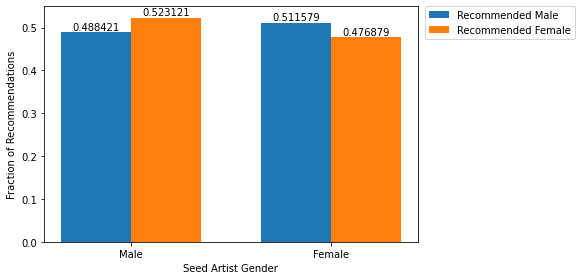

In [15]:
# create bar plot to visualize the fractions

labels = ['Male', 'Female']
maleseed_fracs = [(seedM_recM/total_seedM), (seedM_recF/total_seedM)]
femaleseed_fracs = [(seedF_recM/total_seedF), (seedF_recF/total_seedF)]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, maleseed_fracs, width, label='Recommended Male')
rects2 = ax.bar(x + width/2, femaleseed_fracs, width, label='Recommended Female')

ax.set_ylabel('Fraction of Recommendations')
ax.set_xlabel('Seed Artist Gender')
ax.set_xticks(x, labels)
ax.legend()

ax.bar_label(rects1, padding=0)
ax.bar_label(rects2, padding=0)

fig.tight_layout()

plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

plt.show()

### Figures

<img src="https://i.ibb.co/RPqWw8T/genderbias.jpg" alt="genderbias"  width=600>

<center> Figure 1: Conditional Fractions for the Gender of Recommended and Seed Song Artists</center>

<img src="https://i.ibb.co/pLgzRcy/stats2.jpg" alt="stats2" width=400>

<center> Table 1: Part 1 of the statsmodel summary</center>

<img src="https://i.ibb.co/QKdPQdr/stats.jpg" alt="stats" width=400>

<center> Table 2: Part 2 of the results of the statsmodel summary </center>

# 6 **Discussion**
We can first observe the statsmodel summary of the ordinary least squares model. First, we can take a look at the R-squared value in Table 1 (located at the top right hand corner), which is 0.012, indicating that the model is a bad fit for the data. Next, we can also take a look at the confidence interval values for each of the features. Looking at the rightmost two columns in Table 2, we can see that all of these intervals inlcude 0. This indicates that it is very probable that the coefficient for each of the features are likely to be 0 in the linear regression model. As a result, none of features can be determined to be statistically significant in determining where in the order a song appears in a recommendation output from Spotify's algorithm.

Because the results are statistically insignificant, we cannot make any definitive conclusions about Spotify's algorithm. However, as we consider the limitations of our dataset, we can say that at least for this sample of the first 20 recommendations of the algorithm, there is no bias existing that gives preference for one gender over another. This is further supported by what can be inferenced from the bar chart in Figure 1. From left to right, the bars represent the fraction of male artist recommended given a male seed artist, the fraction of female artists recommended given a male seed artist, the fraction of male artists recommended given a female artists, and the fraction of female artists recommended given a male artist. These can be interpreted as the probability of a recommended artist being a certain gender given the gender of the seed artist. 

All of the values are around 0.5, which indicates near equal probability for each gender being recommended given any gender for the artist of the seed song. Given the limitations in our data, more specifically the quantity, this result may be flawed, but gives unexpected hope that the algorithm puts forth artists of different genders equally when choosing recommendations. We can say that within the first 20 songs of the output of Spotify's recommendation algorithm, there exists no bias towards the gender of the artist. 

# 7 **Takeaway**
Considering the results discussed from our analysis, we do not think any immediate actions should be taken as a result of our findings. From our results, we see that there is no factor amongst the features of the recommended songs that we compared that could be used as determining factors for the ranking of a song in the recommendation list. We found that there was no significant difference in the proportion that Spotify recommended male artists to the proportion that Spotify recommended female artists, when given that the seed song artist is male or female. Therefore, with our current results, accountability does not yet have to be taken.

There were limitations and possibilities of error in the process of conducting our study, which may explain why we did not find much statistical significance in our results. One issue is the lack of manpower and therefore, the lack of ability to produce a larger dataset. Since Spotify's API did not store the gender of an artist, we had to manually label all of the artists’ gender, which was time consuming. As a result, we were only able to get a dataset of 2000 recommended songs. Another problem was that there might have been bias by created by using the API key of a personal Spotify account. 

In the case that gender bias may be identified in Spotify's recommendation algorithm, we would seek accountability from Spotify in the form of an explanation of the design of their recommendation algorithm, as well as the possibility of redesigning the algorithm in order to mitigate the harms of gender bias caused by it. 
